# Transition period for EIP 1559

###### October 2020

---

In this notebook we model and simulate the transition period suggestested in [Pull Request 2924](https://github.com/ethereum/EIPs/pull/2924). To simulate the transition period we will use a few classes from our [`abm1559`](https://github.com/barnabemonnot/abm1559) library, as well as the Strategic User presented in the [previous notebook](https://github.com/barnabemonnot/abm1559/blob/master/notebooks/stationary1559.ipynb).

In [2]:
%config InlineBackend.figure_format = 'svg'

import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
# You may remove the two lines above if you have installed abm1559 from pypi

from typing import Sequence, Dict

from abm1559.utils import (
    constants,
    basefee_from_csv_history,
    get_basefee_bounds,
    flatten
)

from abm1559.txpool import TxPool

from abm1559.users import (
    User1559,
    AffineUser,
    User
)

from abm1559.config import rng

from abm1559.txs import Transaction, Tx1559, TxLegacy

from abm1559.userpool import UserPool

from abm1559.chain import (
    Chain,
    Block1559,
    Block
)

from abm1559.simulator import (
    spawn_poisson_heterogeneous_demand,
    update_basefee,
    generate_gbm,
)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import seaborn as sns
from tqdm import tqdm

## Setting up the simulation

### Legacy tooling for EIP 1559 environment

We assume that during the transitional period, part of the ecosystem will remain using legacy tooling and creating transactions of the legacy format. There is a question of how this legacy tooling that isn't upgraded to have visibility and use `1559` will interact with the overall system. 

To deal with that issue the Pull Request suggests that Legacy Transactions get normalized into `1559` transactions using a simple normalization function. There is the open question of how the legacy APIs will implement and normalize the fields. For the simulations we assume an inverse of the `normalize_from_legacy` is used, where the `max_fee` and `gas_premium` variables are just treated as `gas_price` to keep interoperability during the transition period.

In [3]:
def normalize_from_legacy(legacy: TxLegacy) -> Tx1559:
    """
    Normalized according to
    https://github.com/ethereum/EIPs/blob/541c8be92fe759aa602b7d06a088ab1a139e37ce/EIPS/eip-1559.md
    """
    normalized_params = {
        "max_fee": legacy.gas_price(),
        "gas_premium": legacy.gas_price(),
        "start_block": legacy.start_block,
    }
    return Tx1559(
        sender=legacy.sender,
        tx_params=normalized_params
    )

def normalize_to_legacy(input_tx: Tx1559, basefee: int) -> TxLegacy:
    """
    Normalises the environment variables so legacy tooling is able to interact with 1559
    """
    
    normalized_params = {
        "gas_price": input_tx.gas_price({ "basefee": basefee }),
        "start_block": input_tx.start_block,
    }
    return TxLegacy(
        sender=input_tx.sender,
        tx_params=normalized_params
    )

Next we introduce Legacy agents with strategic behaviours that are analogous to different gas price estimation methods currently being used.

### Legacy users

We start with the Web3Js library, which sets gas prices for transactions on the [web3.eth.gasPrice](https://github.com/ethereum/web3.js/blob/79a4ce4e330605d0b7a508899f53c759d701c197/DOCUMENTATION.md#web3ethgasprice).
Agents that use Web3Js for gas prediction, set their prices as the median of the price over the last `n` blocks. User bids this, if no tx data is available, it uses the minimum gas price as seen in the environment (this is a workaround for when there are no blocks present in the history - as that sets an initial bid set as the minimum `gas_premium`)

One last issue stands before we are able to simulate the legacy market together with the new proposed 1559 mechanism. How will the legacy users understand the new environment? Here we suggest a naive normalization function that translates how the market can be translated to work with the new mechanism.

In [4]:
def normalize_environment(env):
    normalized_blocks = []
    if env["recent_blocks"]:
        for block in env["recent_blocks"]:
            if block.txs:
                normalized_txs = [normalize_to_legacy(tx, block.basefee) for tx in block.txs]
                normalized_block = Block(normalized_txs, block.parent_hash, block.height)
                normalized_blocks.append(normalized_block)
            else:
                continue
    
    normalized_env = {
        **env,
        "recent_blocks": normalized_blocks,
    }
    return normalized_env

This is a simplified version of the EthGasStation model. Instead of doing a Poisson Regression based on confirmation time for a transaction then extracting the percentiles, we just extract the percentiles. The confirmation time of a transaction can be represented as `time tx included in a block - time tx propagated to network`

In [5]:
class LegacyPercentileBidder(AffineUser):
    def __init__(self, wakeup_block, **kwargs):
        super().__init__(wakeup_block, cost_per_unit = 0, **kwargs)
        self.value = self.rng.pareto(3) * 100 * (10 ** 9)

    def percentile(self):
        raise Exception("Not implemented, try using a subclass.")

    def decide_parameters(self, env: dict):
        gas_price = self.query_oracle(env)
        gas_price += self.percentile() / 100.0 * self.rng.pareto(2) * (10 ** 9)
        return {
            "gas_price": int(gas_price), # in wei
            "start_block": self.wakeup_block,
        }
    
    # This function is the main user entry point 
    def create_transaction(self, env: dict):
        tx_params = self.decide_parameters(env)
        
        # If gas price is higher than 1.1 * my value, I balk
        if tx_params["gas_price"] >= 1.1 * self.value:
            return None
                
#         expected_payoff = self.value - tx_params["gas_price"]
#         if expected_payoff <= 0:
#             return None
        
        tx = TxLegacy(
            sender = self.pub_key,
            tx_params = tx_params,
        )
        return tx

In contrast with our previous notebooks, users here do not experience a cost for waiting, so it is set to zero in the `__init__` constructor. We also change the distribution of values, previously a simple uniform distribution over the interval $[1, 20]$ to a [Pareto distribution](https://en.wikipedia.org/wiki/Pareto_distribution) (a.k.a., the 80/20 law).

The choice is made to reflect the actual distribution of bids in a more realistic manner, with most users having relatively low value and few users having relatively high value. Note that the scaling of the distribution is rather irrelevant, since we focus on relative differences between users, but we scale the distribution to match observed prices on eth1. Given here is the distribution of a thousand samples from our value distribution (in Gwei).

array([[<AxesSubplot:title={'center':'value'}>]], dtype=object)

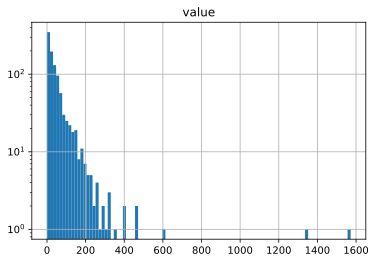

In [32]:
pd.DataFrame({ "value": rng.pareto(3, 1000) * 100 }).hist(log=True, bins = 100)

We instantiate three types of users, one for each oracle level ("slow", "medium" and "fast").

In [7]:
class LegacyPercentileBidderSlow(LegacyPercentileBidder):
    def query_oracle(self, env: dict):
        return env["median_fee"]
    
    def percentile(self):
        return 50
    
    def export(self):
        return {
            **super().export(),
            "user_type": "user_percentile_slow",
        }

class LegacyPercentileBidderMedium(LegacyPercentileBidder):
    def query_oracle(self, env: dict):
        return env["fee_75"]
    
    def percentile(self):
        return 75
    
    def export(self):
        return {
            **super().export(),
            "user_type": "user_percentile_medium",
        }

class LegacyPercentileBidderFast(LegacyPercentileBidder):
    def query_oracle(self, env: dict):
        return env["fee_90"]
    
    def percentile(self):
        return 90
    
    def export(self):
        return {
            **super().export(),
            "user_type": "user_percentile_fast",
        }

### Bidding bots

A special class of high-value users exist on the network too. These users post transactions closing collateralised positions, arbitraging fees on DEXes or bidding for first inclusion. This is where the highest fees are observed, as the largest admissible fee for these transactions is the size of their profit opportunity, which in the three cases mentioned above can be pretty huge. (For more on MEV and bidding wars, check out [Phil Daian et al., _Flashbots 2.0_ paper](https://arxiv.org/abs/1904.05234)).

Although the behaviour of bots acting on behalf of MEV-chasing users is complex, involving bidding wars and real-time analysis of the transaction pool, we'll use a simple model of an extremely risk averse user. The user observes the "fast" oracle and posts a gas price somewhere between that oracle and its own (high) value.

In [35]:
class RiskAverseLegacyUser(AffineUser):
    def __init__(self, wakeup_block, **kwargs):
        super().__init__(wakeup_block, cost_per_unit = 0, **kwargs)
        self.value = self.rng.pareto(3) * 300 * (10 ** 9)

    def percentile(self):
        raise Exception("Not implemented, try using a subclass.")

    def decide_parameters(self, env: dict):
        oracle_price = env["fee_90"]
        gas_price = oracle_price + self.rng.random() * (self.value - oracle_price)
        return {
            "gas_price": int(gas_price), # in wei
            "start_block": self.wakeup_block,
        }
    
    # This function is the main user entry point 
    def create_transaction(self, env: dict):
        tx_params = self.decide_parameters(env)
                
        expected_payoff = self.value - tx_params["gas_price"]
        if expected_payoff <= 0:
            return None
        
        tx = TxLegacy(
            sender = self.pub_key,
            tx_params = tx_params,
        )
        return tx
    
    def export(self):
        return {
            **super().export(),
            "user_type": "beep_boop",
        }

### Transaction and user pools

New transaction pool that normalizes transactions.
We use the same simulation loop as before, but we allow agents to have visibility on recent blocks through the `env` variable.

For performance reasons, we create a userpool that normalizes the environment for the user, so the operation doesn't need to be repeated multiple times.

In [36]:
MAX_TRANSACTIONS_IN_POOL = 10000
MIN_ACCEPTABLE_TIP = 1 * (10 ** 9)

class MixedTxPool(TxPool):
    
    def add_txs(self, txs: Sequence[Transaction], env: dict) -> None:
        for tx in txs:
            if type(tx) is TxLegacy:
                tx = normalize_from_legacy(tx)
            self.txs[tx.tx_hash] = tx
        
        self.pool_length += len(txs)
            
        if self.pool_length > MAX_TRANSACTIONS_IN_POOL:
            sorted_txs = sorted(self.txs.values(), key = lambda tx: -tx.tip(env))
            self.empty_pool()
            self.add_txs(sorted_txs[0:MAX_TRANSACTIONS_IN_POOL], env)
            return sorted_txs[MAX_TRANSACTIONS_IN_POOL:]
        
        return []
    
    def select_transactions(self, env, user_pool=None, rng=rng):
        # Miner side
        max_tx_in_block = int(constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"])

        valid_txs = [tx for tx in self.txs.values() if tx.is_valid(env) and tx.tip(env) >= MIN_ACCEPTABLE_TIP]
        rng.shuffle(valid_txs)

        sorted_valid_demand = sorted(
            valid_txs,
            key = lambda tx: -tx.tip(env)
        )
        selected_txs = sorted_valid_demand[0:max_tx_in_block]

        return selected_txs
    
class MixedUserPool(UserPool):
    def decide_transactions(self, users: Sequence[User], env: Dict) -> Sequence[Transaction]:
        txs = []
        normalized_environment = normalize_environment(env)
        for user in users:
            self.users[user.pub_key] = user
            if (isinstance(user, LegacyPercentileBidder)):
                tx = user.transact(normalized_environment)
            else:
                tx = user.transact(env)
            if not tx is None:
                txs.append(tx)

        return txs

This is not an accurate measure but serves as an interesting starting point given previous demand. This does not take into account block producer incentives to go over the gas target, and assumes the blocks would be filled as they were historically.

### The market price

Block space allocation is a dynamic process with a queue of users competing for scarce resources. Although first price auctions are an imprecise mechanism to allocate the resources to users efficiently, they provide an estimator of some true **market price**. We define market price as the actual gas price that ought to be quoted to exactly equalise demand with supply. How can we find it in our setting?

We target the inclusion of some number of users $T$ in the block (recall that all users have the same, constant demand for gas). New users come in between each block, while the pool holds at most 10,000 unincluded users, ranked by their tip amount. Before a new block is created, we take a "snapshot" of the current state: a set of new users with values for gas $(v_i)_i$, and a set of pending transactions with gas prices $(g_j)_j$. We now sort the values and gas prices in decreasing order, obtaining a sequence of "prices" $(p_k)_k$. Taking $p_T$, the $T$-th price in the sequence, we estimate the true market price that equalises supply with the demand given the snapshot $(v, g)$.

There are at least two other ways to estimate the true market price.

1. Associate each transaction $j$ in the transaction pool with the user who sent it, and use the value of that user $v_j$ instead of the gas price $g_j$ of the transaction. This is likely a "truer" price of the current market, but it is also not a very useful one. There is nothing the user can do now that they sent their transaction in, so the market must decide to allocate space between existing transactions and the new users.
2. Let new users post their transactions, record the gas prices $(g_i)_i$ of these new transactions and use that instead of the new users' values $(v_i)_i$. This price is the most concrete estimation of the realised market state, but may be biased towards the bidding strategies of new users, since the gas price is in general not equal to the user's value.

In a sense, we look for a value that answers the question: "In a world where the market has full information about user values, which _uniform_ price should the market quote to maximise the amount collected?"

We give in `get_market_price` the implementation of this estimator. Note that when we have less users and transactions than the target amount, the price is set to 0, since there is no scarcity. In practice, we could set this no-scarcity price to the minium fee miners expect from a transaction, although this makes no difference in the following.

In [37]:
def get_market_price(users: Sequence[User], txs: Sequence[Transaction], env: dict, target: int) -> float:
    values = sorted(
        [user.value for user in users] + [tx.gas_price(env) for tx in txs],
        key = lambda v: -v
    )
    return values[target] if target < len(values) else 0

### The main simulation loop

In [38]:
# initial_historic_basefee = basefee_from_csv_history(
#     constants["INITIAL_BASEFEE"],
#     '../txs-sample-10932001-10942000.csv'
# )
# print(initial_historic_basefee / 10**9)

In [39]:
def simulate(demand_scenario, shares_scenario, extra_metrics):
    # Instantiate a couple of things
    txpool = MixedTxPool()
    chain = Chain()
    metrics = []
    user_pool = MixedUserPool()
    blocks_window = 5
    start_time = time.time()
    
    # `env` is the "environment" of the simulation
    env = {
        # we start with the historic basefee based on previous txs
        "basefee": constants["INITIAL_BASEFEE"],
        # "basefee": initial_historic_basefee,
        "current_block": None,
        "min_premium": 2 * (10 ** 9),
        "recent_blocks": [],
        "median_fee": 2 * (10 ** 9),
        "fee_75": 2 * (10 ** 9),
        "fee_90": 2 * (10 ** 9),
    }

    for t in tqdm(range(len(demand_scenario))):
        # set current block
        env["current_block"] = t
        
        ### SIMULATION ###

        # We return some demand which on expectation yields `demand_scenario[t]` new users per round
        users = spawn_poisson_heterogeneous_demand(t, demand_scenario[t], shares_scenario[t])
        
        # Record the market price given the current snapshot
        market_price = get_market_price(
            users,
            txpool.txs.values(),
            env,
            int(constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"] / 2.0)
        )

        # Add new users to the pool
        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, env)

        # New transactions are added to the transaction pool
        # `evicted_txs` holds the transactions removed from the pool for lack of space
        evicted_txs = txpool.add_txs(decided_txs, env)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(env)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = Block1559(
            txs = selected_txs, parent_hash = chain.current_head,
            height = t, basefee = env["basefee"]
        )
        env["recent_blocks"] = env["recent_blocks"][-(blocks_window-1):] + [block]
        # Record the min premium in the block
        env["min_premium"] = block.min_premium()
        
        # The block is added to the chain
        chain.add_block(block)
        
        ### METRICS ###
                
        row_metrics = {
            "block": t,
            "basefee": env["basefee"] / (10 ** 9),
            "users": len(users),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "median_fee": env["median_fee"] / (10 ** 9),
            "fee_75": env["fee_75"] / (10 ** 9),
            "fee_90": env["fee_90"] / (10 ** 9),
            "market_price": market_price  / (10 ** 9),
            "blk_min_premium": block.min_premium() / (10 ** 9), # to Gwei
            "blk_max_premium": block.max_premium() / (10 ** 9), # to Gwei
            "blk_min_tip": block.min_tip(env) / (10 ** 9), # to Gwei
            "blk_max_tip": block.max_tip(env) / (10 ** 9), # to Gwei
            **extra_metrics(env, users, user_pool, txpool),
        }
        metrics.append(row_metrics)

        ### ORACLES ###
        
        fees = flatten(
            [[tx.gas_price() for tx in block.txs] for block in normalize_environment(env)["recent_blocks"]]
        )
        env["median_fee"] = np.percentile(fees, 50)
        env["fee_75"] = np.percentile(fees, 75)
        env["fee_90"] = np.percentile(fees, 90)
        
        # Finally, basefee is updated and a new round starts
        env["basefee"] = update_basefee(block, env["basefee"])

    return (pd.DataFrame(metrics), user_pool, chain)

## Benchmark cases

The simulation loop above defines a 1559-environment. There is a basefee determining transaction validity and blocks are created with 1559-formatted transactions (with `max_fee` and `gas_premium` fields). In this environment, we start by looking at two scenarios.

1. In the first, we only have legacy users posting transactions in this 1559-environment. Legacy users are unaware of the presence of a basefee. They produce their transactions using the oracles as their sole source of market information. The transactions are legacy-formatted, setting the `gas_price` field to the amount desired by the user.
2. In the second, we simulate 1559 users as we have done in previous notebooks, e.g., [Strategic users in 1559](https://nbviewer.jupyter.org/github/barnabemonnot/abm1559/blob/master/notebooks/strategicUser.ipynb). These users know about the basefee and use its current value to produce their transactions, which contain `max_fee` and `gas_premium` attributes.

Before launching into these scenarios, we discuss the demand process in this notebook.

### Generating the demand

In previous notebooks, we've always used a stationary demand to simulate the behaviour of the mechanism. This is a good assumption to obtain the stationary behaviour of the basefee and 1559 users, but is obviously a gross simplification of the real world. Demand can be made non-stationary in two ways:

1. The amount of new users is drawn from a different distribution each step.
2. User values change over time.

While 2. is a probably a better representation of systemic shocks (e.g., introduction of a new token or contract), 1. appears to reflect better more natural chain activity, with high and low demand regimes. This is the choice we make in this notebook.

We generate a sample path from a geometric Brownian motion (GBM) with $\mu = \frac{\sigma^2}{2}$ to remove any trend. The path has some value $d_t$ at each time step $t$. We then sample from a Poisson distribution of mean $d_t$ to obtain the actual number of users spawned at time step $t$. Note that $d_t$ may be a decimal number, but the Poisson sample will always be integer-valued.

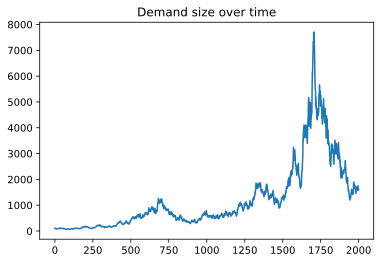

In [40]:
blocks = 2000

rng = np.random.default_rng(3)
sigma = 0.05
mu = 0.5 * sigma**2
gbm = list(generate_gbm(100, blocks, paths=1, mu=mu, sigma=sigma, rng=rng).flatten())

# Plot demand
f = plt.figure()
plt.title('Demand size over time', color='black')
plt.plot(range(blocks), gbm)
plt.show()

### Scenario 1: All legacy users

In this scenario, only legacy users interact in a 1559-environment. We instantiate constant fractions of each user type each step, while the absolute number of users follows the demand process generated by the GBM sample path.

In particular, following a rough intuition of Pareto-law distributed users, we imagine that most users have relatively low hurry, while some users are willing to pay greater amounts for faster inclusion. This assumption is implemented with the following shares of user types:

In [41]:
def extra_metrics_fpa(env, users, user_pool, txpool):
    pool_percentile_users = len(
        [tx for tx in txpool.txs.values() if isinstance(user_pool.users[tx.sender], LegacyPercentileBidder)])

    return {
        "percentile": len([user for user in users if isinstance(user, LegacyPercentileBidder)]),
        "pool_percentile": pool_percentile_users
    }

In [42]:
# Number of new users per time step
demand_scenario = [gbm[t] for t in range(2000)]

# Shares of new users per time step
shares_scenario = [{
    LegacyPercentileBidderSlow: 0.50,
    LegacyPercentileBidderMedium: 0.30,
    LegacyPercentileBidderFast: 0.15,
    RiskAverseLegacyUser: 0.05,
} for t in range(blocks)]

(df, user_pool, chain) = simulate(demand_scenario, shares_scenario, extra_metrics_fpa)

100%|██████████| 2000/2000 [01:34<00:00, 21.18it/s]


In [43]:
df[df.block > 1950]

,block,basefee,users,decided_txs,included_txs,median_fee,fee_75,fee_90,market_price,blk_min_premium,blk_max_premium,blk_min_tip,blk_max_tip,percentile,pool_percentile
1951,1951,394.518000,1467,88,5,356.755426,360.842065,511.526069,420.420505,511.613953,517.170536,117.095953,122.652537,1393,9630
1952,1952,350.381298,1509,66,95,357.093730,361.355666,548.719384,386.753977,357.228573,1141.604185,6.847275,791.222887,1432,9601
1953,1953,393.959972,1607,85,13,357.817395,361.410904,509.759054,447.886238,509.978640,919.663473,116.018667,525.703500,1526,9673
1954,1954,358.158860,1494,98,95,360.836779,363.642623,550.732693,419.698067,361.156270,783.770753,2.997410,425.611893,1419,9676
1955,1955,402.704868,1506,80,3,361.425578,364.022934,550.424328,414.939512,550.497187,832.416137,147.792319,429.711269,1429,9753
1956,1956,355.538060,1467,64,95,361.713996,364.557029,551.132260,386.245463,361.795552,713.795781,6.257492,358.257720,1393,9722
1957,1957,399.758107,1534,87,11,362.286499,364.754838,550.911690,451.633243,551.108808,1352.091488,151.350702,952.333381,1457,9798
1958,1958,361.331359,1483,58,95,364.029092,366.090755,575.343784,372.020444,362.766420,1637.958935,1.435061,1276.627577,1407,9761
1959,1959,406.271946,1510,75,8,364.306506,365.978889,551.352252,435.201688,551.511181,1413.245585,145.239234,1006.973639,1434,9828
1960,1960,364.019664,1460,75,90,364.806866,366.337440,552.362904,422.945481,365.027730,688.463484,1.008066,324.443820,1387,9813


<AxesSubplot:xlabel='block'>

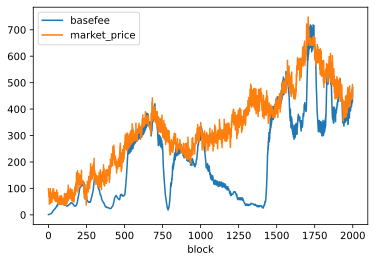

In [44]:
df.plot("block", ["basefee", "market_price"])

<AxesSubplot:xlabel='block'>

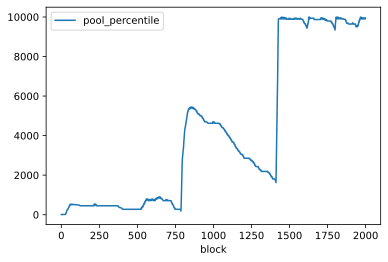

In [45]:
df.plot("block", ["pool_percentile"])

<AxesSubplot:xlabel='block'>

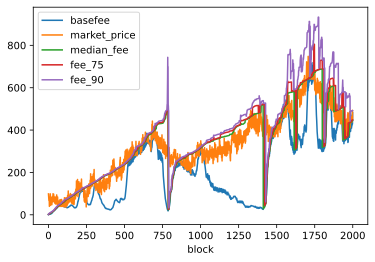

In [46]:
df.plot("block", ["basefee", "market_price", "median_fee", "fee_75", "fee_90"])

<AxesSubplot:xlabel='block'>

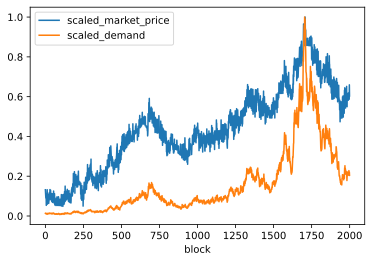

In [47]:
df["scaled_market_price"] = df["market_price"] / max(df["market_price"])
df["scaled_demand"] = df["users"] / max(df["users"])
df.plot("block", ["scaled_market_price", "scaled_demand"])

In [48]:
# Obtain the pool of users (all users spawned by the simulation)
user_pool_df = user_pool.export().rename(columns={ "pub_key": "sender" })

# Export the trace of the chain, all transactions included in blocks
chain_df = chain.export()

# Join the two to associate transactions with their senders
user_txs_df = chain_df.join(user_pool_df.set_index("sender"), on="sender")

In [49]:
txs_per_user_type = user_txs_df.groupby(
    ["block_height", "user_type"]
).agg(
    { "user_type": len }
).unstack(level=-1).reset_index()

txs_per_user_type["user_type"] = txs_per_user_type["user_type"].fillna(0)

txs_per_user_type.columns = [
    "block_height", "bidding_bot", "percentile_fast", "percentile_medium", "percentile_slow"
]

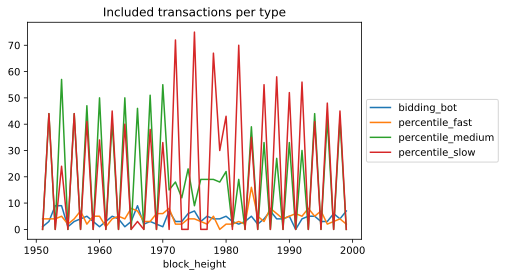

In [50]:
f = plt.figure()

plt.title('Included transactions per type', color='black')
txs_per_user_type[txs_per_user_type.block_height > 1950].plot(
    "block_height",
    ["bidding_bot", "percentile_fast", "percentile_medium", "percentile_slow"],
    ax=f.gca()
)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

### Scenario 2: All 1559 users

In this scenario, we reproduce the situation analysed in [Strategic users in 1559](https://nbviewer.jupyter.org/github/barnabemonnot/abm1559/blob/master/notebooks/strategicUser.ipynb). We have two types of users:

- `OptimisticUser`: simply takes the basefee plus the minimum miner premium as their bid.
- `StrategicUser`: takes the basefee plus the minimum premium observed in the previous block, plus a small increment to outbid other users.

As we've seen in the [Strategic users in 1559](https://nbviewer.jupyter.org/github/barnabemonnot/abm1559/blob/master/notebooks/strategicUser.ipynb) notebook, strategic users are competitive in times of large upward demand shifts (when basefee is "excessively low", in the terms of [Tim Roughgarden's report](http://timroughgarden.org/papers/eip1559.pdf)), but their outbidding is irrelevant otherwise.

In [52]:
class OptimisticUser(User1559):
    def __init__(self, wakeup_block, **kwargs):
        super().__init__(wakeup_block, cost_per_unit = 0, **kwargs)
        self.value = self.rng.pareto(3) * 100 * (10 ** 9)

class StrategicUser(User1559):
    """
    A strategic affine user sending 1559 transactions.

    - Expects to be included in the next block
    - Prefers not to participate if its expected payoff is negative
    - Strategic gas_premium
    """

    epsilon = 0.1 # how much the user overbids by

    def __init__(self, wakeup_block, **kwargs):
        super().__init__(wakeup_block, cost_per_unit = 0, **kwargs)
        self.value = self.rng.pareto(3) * 100 * (10 ** 9)

    def decide_parameters(self, env):
        if env["min_premium"] is None:
            min_premium = 1 * (10 ** 9)
        else:
            min_premium = env["min_premium"]

        gas_premium = min_premium + self.epsilon * (10 ** 9)
        max_fee = self.value

        return {
            "max_fee": max_fee, # in wei
            "gas_premium": gas_premium, # in wei
            "start_block": self.wakeup_block
        }

    def export(self):
        return {
            **super().export(),
            "user_type": "strategic_user_1559",
        }

    def __str__(self):
        return f"1559 strategic affine user with value {self.value} and cost {self.cost_per_unit}"

Let's simulate!

In [53]:
def extra_metrics_1559(env, users, user_pool, txpool):
    pool_strat_users = len(
            [tx for tx in txpool.txs.values() if type(user_pool.users[tx.sender]) is StrategicUser])
    pool_nonstrat_users = len(
            [tx for tx in txpool.txs.values() if type(user_pool.users[tx.sender]) is OptimisticUser])
    return {
        "strategic": len([user for user in users if type(user) is StrategicUser]),
        "nonstategic": len([user for user in users if type(user) is OptimisticUser]),
        "pool_strategic": pool_strat_users,
        "pool_nonstrat": pool_nonstrat_users,
    }

In [54]:
# Number of new users per time step
demand_scenario = [gbm[t] for t in range(2000)]

# Shares of new users per time step
shares_scenario = [{
    StrategicUser: 0.90,
    OptimisticUser: 0.10,
} for t in range(blocks)]

(df_1559, user_pool_1559, chain_1559) = simulate(demand_scenario, shares_scenario, extra_metrics_1559)

100%|██████████| 2000/2000 [01:58<00:00, 16.90it/s]


In [55]:
df_1559

,block,basefee,users,decided_txs,included_txs,median_fee,fee_75,fee_90,market_price,blk_min_premium,blk_max_premium,blk_min_tip,blk_max_tip,strategic,nonstategic,pool_strategic,pool_nonstrat
0,0,1.000000,110,106,95,2.000000,2.000000,2.000000,30.063494,2.1,2.1,2.1,2.1,99,11,0,11
1,1,1.124375,106,96,95,3.100000,3.100000,3.100000,31.241688,1.0,2.2,1.0,2.2,95,11,0,12
2,2,1.264219,95,92,95,3.100000,3.324375,3.324375,25.127648,1.0,1.1,1.0,1.1,85,10,0,9
3,3,1.421456,90,83,92,3.100000,3.324375,3.324375,22.136729,1.0,1.1,1.0,1.1,81,9,0,0
4,4,1.587056,96,87,87,2.521456,3.100000,3.324375,28.897752,1.0,1.1,1.0,1.1,86,10,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,225.362221,1767,53,53,237.032005,238.493757,241.846943,241.431416,1.0,1.1,1.0,1.1,1590,177,0,0
1996,1996,228.545463,1733,47,47,237.032005,238.493757,241.846943,229.268937,1.0,1.1,1.0,1.1,1559,174,0,0
1997,1997,228.174076,1706,43,43,233.552008,237.032005,241.846943,213.457154,1.0,1.1,1.0,1.1,1535,171,0,0
1998,1998,225.407466,1692,70,70,229.645463,233.552008,237.032005,278.305396,1.0,1.1,1.0,1.1,1522,170,0,0


<AxesSubplot:xlabel='block'>

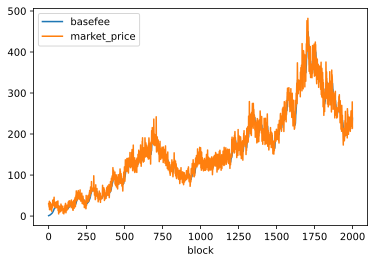

In [56]:
df_1559.plot("block", ["basefee", "market_price"])

<AxesSubplot:xlabel='block'>

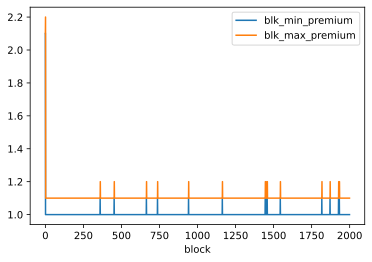

In [57]:
df_1559.plot("block", ["blk_min_premium", "blk_max_premium"])

<AxesSubplot:xlabel='block'>

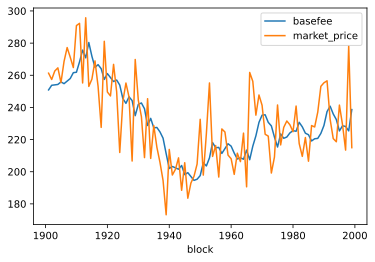

In [58]:
df_1559[df_1559.block > 1900].plot("block", ["basefee", "market_price"])

In [59]:
# L2 distance between market price vs basefee and market price vs 90th percentile oracle ("fast")
basefee_diff = np.sqrt(np.sum((df_1559["market_price"] - df_1559["basefee"]) ** 2))
fpa_diff = np.sqrt(np.sum((df["market_price"] - df_1559["fee_90"]) ** 2))
basefee_diff, fpa_diff

(750.9994886849883, 7755.504304424844)

### Transactions included per user type

In [ ]:
txs_per_user_type = user_txs_df.groupby(
    ["block_height", "user_type"]
).agg(
    { "user_type": len }
).unstack(level=-1).reset_index()

txs_per_user_type["user_type"] = txs_per_user_type["user_type"].fillna(0)

txs_per_user_type.columns = [
    "block_height", "percentile_fast", "percentile_medium", "percentile_slow"
]

In [ ]:
f = plt.figure()

plt.title('Included transactions per type', color='black')
txs_per_user_type[txs_per_user_type.block_height > 1750].plot(
    "block_height",
    ["percentile_fast", "percentile_medium", "percentile_slow"],
    ax=f.gca()
)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
f = plt.figure()

plt.title('Included transactions per type (cold start)', color='black')
txs_per_user_type[
    txs_per_user_type.block_height < 50
].plot(
    "block_height",
    ["strategic", "nonstrategic", "legacy",
     "percentile_fast", "percentile_medium", "percentile_slow", "web3js"],
    ax=f.gca()
)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

### Gas price per user type

In [ ]:
user_txs_df["gas_price"] = user_txs_df.apply(
    lambda row: row.tx.gas_price({ "basefee": row.basefee * (10 ** 9) }) / (10 ** 9),
    axis = 1
)

gas_price_per_user_type = user_txs_df[["block_height", "user_type", "gas_price"]].groupby(
    ["block_height", "user_type",]
).agg(
    { "gas_price": np.mean }
).unstack(level=-1).reset_index()

gas_price_per_user_type.columns = [
    "block_height", "strategic", "nonstrategic", "legacy",
    "percentile_fast", "percentile_medium", "percentile_slow", "web3js"]

In [ ]:
f = plt.figure()

plt.title('Gas price per type', color='black')
gas_price_per_user_type.plot(
    "block_height",
    ["strategic", "nonstrategic", "legacy",
     "percentile_fast", "percentile_medium", "percentile_slow", "web3js"],
    ax=f.gca()
)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
f = plt.figure()

plt.title('Gas price per type (cold start)', color='black')
gas_price_per_user_type[gas_price_per_user_type.block_height < 50].plot(
    "block_height",
    ["strategic", "nonstrategic", "legacy",
     "percentile_fast", "percentile_medium", "percentile_slow", "web3js"],
    ax=f.gca()
)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
f = plt.figure()

plt.title('Increasing gas price', color='black')
gas_price_per_user_type[
    (gas_price_per_user_type.block_height > 200) & (gas_price_per_user_type.block_height < 400)
].plot(
    "block_height", [
        "strategic", "nonstrategic", "legacy", "percentile_fast", "percentile_medium", "percentile_slow", "web3js"
    ],
    ax=f.gca()
)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

### Tip per user type

In [ ]:
user_txs_df["tip"] = user_txs_df.apply(
    lambda row: row.tx.tip({ "basefee": row.basefee * (10 ** 9) }) / (10 ** 9),
    axis = 1
)

tip_per_user_type = user_txs_df[["block_height", "user_type", "tip"]].groupby(
    ["block_height", "user_type",]
).agg(
    { "tip": np.mean }
).unstack(level=-1).reset_index()

tip_per_user_type.columns = [
    "block_height", "strategic", "nonstrategic", "legacy",
    "percentile_fast", "percentile_medium", "percentile_slow", "web3js"]

In [ ]:
f = plt.figure()

plt.title('Tip per user type', color='black')
tip_per_user_type.plot(
    "block_height",
    ["strategic", "nonstrategic", "legacy", "percentile_fast", "percentile_medium", "percentile_slow", "web3js"],
    ax=f.gca()
)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
f = plt.figure()

plt.title('Tip per user type at discontinuity', color='black')
tip_per_user_type[tip_per_user_type.block_height < 50].plot(
    "block_height",
    ["strategic", "nonstrategic", "legacy", "percentile_fast", "percentile_medium", "percentile_slow", "web3js"],
    ax=f.gca()
)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
f = plt.figure()

plt.title('Tip per user type at increasing demand', color='black')
tip_per_user_type[
    (tip_per_user_type.block_height > 150) & (tip_per_user_type.block_height < 230)
].plot(
    "block_height",
    ["strategic", "nonstrategic", "legacy", "percentile_fast", "percentile_medium", "percentile_slow", "web3js"],
    ax=f.gca()
)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

---

## Tax

Now we add a tax to transactions. The tax can be viewed as:

User bids `n` gwei, and pays for `n` gwei.
The transaction's gas price at block `m` is `f(n, m)` where `f(n, m) < n` and `f(n, m) < f(n, m + 1)`

Use linear / exponential / gauss decay? 

This means the tax function is monotonic, where legacy transactions that get taxed are less likely to get included due to their higher cost for the user and lower return for the block producer. The tax revenue can either be burnt or used for funding of public goods through mechanisms such as Quadratic Funding.

In [ ]:
tax_start_block = 5
tax = lambda n, m: n * (tax_start_block / m)

# Add tax to selected txs that are legacy
class MixedTaxTxPool(MixedTxPool):
    def select_transactions(self, params):
        # Miner side
        basefee = params["basefee"]
        max_tx_in_block = int(constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"])

        valid_txs = [tx for tx in self.txs.values() if tx.is_valid({ "basefee": basefee })]
        rng.shuffle(valid_txs)

        sorted_valid_demand = sorted(
            valid_txs,
            key = lambda tx: -tx.tip({ "basefee": basefee })
        )
        selected_txs = sorted_valid_demand[0:max_tx_in_block]

        return selected_txs

In [ ]:
def simulate(demand_scenario, shares_scenario):
    # Instantiate a couple of things
    txpool = MixedTxPool()
    chain = Chain()
    metrics = []
    user_pool = MixedUserPool()
    
    # `params` are the "environment" of the simulation
    params = {
        # we start with the historic basefee based on previous txs
        "basefee": constants["INITIAL_BASEFEE"],
        # "basefee": initial_historic_basefee,
        "current_block": None,
        "min_premium": 1 * (10 ** 9),
        "recent_blocks": [],
    }

    for t in range(len(demand_scenario)):
        # set current block wi
        params["current_block"] = t

        # We return some demand which on expectation yields 2000 new users per round
        users = spawn_poisson_heterogeneous_demand(t, demand_scenario[t], shares_scenario[t])

        # Add new users to the pool
        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, params)

        # New transactions are added to the transaction pool
        txpool.add_txs(decided_txs)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = Mi.select_transactions(params)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = params["basefee"])
        params["recent_blocks"].append(block)
        # Record the min premium in the block
        params["min_premium"] = block.min_premium()

        # The block is added to the chain
        chain.add_block(block)

        # A couple of metrics we will use to monitor the simulation
        # A couple of metrics we will use to monitor the simulation
        pool_strat_users = len(
                [tx for tx in txpool.txs.values() if type(user_pool.users[tx.sender]) == StrategicUser])
        pool_nonstrat_users = len(
                [tx for tx in txpool.txs.values() if type(user_pool.users[tx.sender]) == OptimisticUser])
        pool_legacy_users = len(
                [tx for tx in txpool.txs.values() if type(user_pool.users[tx.sender]) == LegacyUser])
        pool_web3js_users = len(
                [tx for tx in txpool.txs.values() if type(user_pool.users[tx.sender]) == LegacyWeb3jsUser])

        row_metrics = {
            "block": t,
            "basefee": params["basefee"] / (10 ** 9),
            "users": len(users),
            "strategic": len([user for user in users if type(user) is StrategicUser]),
            "nonstategic": len([user for user in users if type(user) is OptimisticUser]),
            "legacy": len([user for user in users if type(user) is LegacyUser]),
            "web3js": len([user for user in users if type(user) is LegacyWeb3jsUser]),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "blk_min_premium": block.min_premium() / (10 ** 9), # to Gwei
            "pool_length": txpool.pool_length,
            "pool_strat_users": pool_strat_users,
            "pool_nonstrat_users": pool_nonstrat_users,
            "pool_legacy_users": pool_legacy_users,
            "pool_web3js_users": pool_web3js_users,
        }
        metrics.append(row_metrics)

        # Finally, basefee is updated and a new round starts
        params["basefee"] = update_basefee(block, params["basefee"])

    return (pd.DataFrame(metrics), user_pool, chain)

### `LegacyUser`

We also include an agent that creates Legacy transactions with the expectation of 5 block wait time

In [ ]:
class LegacyUser(AffineUser):
    """
    An affine user sending Legacy transactions.
    """
    # Prefers not to participate if its expected payoff is negative
    # Fixed gas_premium

    def __init__(self, wakeup_block, **kwargs):
        super().__init__(wakeup_block, cost_per_unit = 0, **kwargs)
        self.value = self.rng.pareto(2) * 30 * (10 ** 9)

    def decide_parameters(self, env):
        gas_price = 0.9 * self.value
        return {
            "gas_price": gas_price, # in wei
            "start_block": self.wakeup_block,
        }

    def create_transaction(self, env: dict):
        tx_params = self.decide_parameters(env)
        
        expected_payoff = self.value - tx_params["gas_price"]
        if expected_payoff <= 0:
            return None
        
        tx = TxLegacy(
            sender = self.pub_key,
            tx_params = tx_params,
        )
        return tx

    def export(self):
        return {
            **super().export(),
            "user_type": "user_legacy",
        }

    def __str__(self):
        return f"Legacy affine user with value {self.value} and cost {self.cost_per_unit}"